<a href="https://colab.research.google.com/github/douglasmmachado/MedicineConsumption/blob/master/notebooks/Division_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the unified database



---



---



In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import math as m
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor


raw_data_url ="https://raw.githubusercontent.com/douglasmmachado/MedicineConsumption/master/datasets/dataset_resampled.csv"
df=pd.read_csv(raw_data_url, index_col=False)

categorical_features = ['ID_REF', 'ID_SITE_RATTACHE', 'CODE_ATC', 'HOSPI_CODE_UCD']
date_features = ['DATE']
numerical_features = ['N_UFS', 'QUANTITY', 'N_ETB', 'POPULATION', 'P_MEDICAL', 'PN_MEDICAL', 'LIT_HC', 'LIT_HP', 'SEJ_MCO', 'SEJ_HAD', 'SEJ_PSY', 'SEJ_SSR']

df['DATE'] = pd.to_datetime(df['DATE'],
               format='%Y-%m-%d')  # Changed the type of date too

for column in categorical_features:
  df[column] = df[column].astype('string')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1997 entries, 0 to 1996
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID_REF            1997 non-null   string        
 1   YEAR              1997 non-null   int64         
 2   MONTH             1997 non-null   int64         
 3   ID_SITE_RATTACHE  1997 non-null   string        
 4   QUANTITY          1997 non-null   float64       
 5   CODE_ATC          1997 non-null   string        
 6   HOSPI_CODE_UCD    1997 non-null   string        
 7   N_UFS             1997 non-null   int64         
 8   WEEK              1997 non-null   float64       
 9   N_ETB             1997 non-null   int64         
 10  POPULATION        1997 non-null   float64       
 11  P_MEDICAL         1997 non-null   int64         
 12  PN_MEDICAL        1997 non-null   int64         
 13  LIT_HC            1997 non-null   float64       
 14  LIT_HP            1997 n

# 1 - Database formatting

## 1.1 - Data inconsistance handling

In [2]:
df = df.drop_duplicates()
df = df.dropna()

for column in numerical_features:
  zeros = (df[column] == 0).sum()
  print(f'Column: {column}' + f' number of zeros: {zeros}')

Column: N_UFS number of zeros: 0
Column: QUANTITY number of zeros: 0
Column: N_ETB number of zeros: 0
Column: POPULATION number of zeros: 0
Column: P_MEDICAL number of zeros: 0
Column: PN_MEDICAL number of zeros: 0
Column: LIT_HC number of zeros: 0
Column: LIT_HP number of zeros: 0
Column: SEJ_MCO number of zeros: 0
Column: SEJ_HAD number of zeros: 1473
Column: SEJ_PSY number of zeros: 459
Column: SEJ_SSR number of zeros: 0


## 1.2 - Separating databases by hospital

In [3]:
# Separating databases

n_medicines = df['ID_REF'].nunique()
print('Number of different medicines: ', n_medicines)
df = df.drop(columns=['DATE'])

df_h1 = df[df["ID_SITE_RATTACHE"] == "HOSPI_1"]
df_h1 = df_h1.drop(columns=['ID_SITE_RATTACHE', 'HOSPI_CODE_UCD'])

df_h2 = df[df["ID_SITE_RATTACHE"] == "HOSPI_2"]
df_h2 = df_h2.drop(columns=['ID_SITE_RATTACHE', 'HOSPI_CODE_UCD'])

df_h3 = df[df["ID_SITE_RATTACHE"] == "HOSPI_3"]
df_h3 = df_h3.drop(columns=['ID_SITE_RATTACHE', 'HOSPI_CODE_UCD'])

df_h4 = df[df["ID_SITE_RATTACHE"] == "HOSPI_4"]
df_h4 = df_h4.drop(columns=['ID_SITE_RATTACHE', 'HOSPI_CODE_UCD'])

Number of different medicines:  84


# Helper functions

In [4]:
'''
   This function helps visualize the values of numerical columns in a DataFrame,
   making it easier to understand their patterns and distributions.
'''

def plot_df(df, n_cols=3):
    numerical_cols = df.select_dtypes(include=[int, float]).columns
    num_features = len(numerical_cols)
    n_rows = (num_features - 1) // n_cols + 1

    fig, axes = plt.subplots(n_rows, n_cols, sharex=False, figsize=(20, 20))

    for i, column in enumerate(numerical_cols):
        values = df[column].dropna()
        if not values.empty:
            ax = axes[i // n_cols, i % n_cols]
            ax.plot(values)
            ax.set_title('Values of: ' + str(column))
            ax.grid(True)
            plt.grid()

    # Remove empty subplots
    if num_features < n_rows * n_cols:
        for i in range(num_features, n_rows * n_cols):
            fig.delaxes(axes[i // n_cols, i % n_cols])

    plt.tight_layout()
    plt.show()


In [234]:
import numpy as np
from sklearn.linear_model import LinearRegression

def plot_actual_vs_predicted(x, y_test, y_pred, x_projection=None, y_projection=None, title='Actual vs Predicted'):
    # Set the figure size
    plt.figure(figsize=(8, 6))

    # Plotting the actual values as scatter plot
    plt.scatter(x, y_test, label='Actual')

    # Plotting the predicted values as scatter plot
    plt.scatter(x, y_pred, label='Predicted')

    # Plotting the projection values as scatter plot if provided
    if x_projection is not None and y_projection is not None:
        plt.scatter(x_projection, y_projection, label='Projection')

    # Adding labels and title
    plt.xlabel('Data Point')
    plt.ylabel('Value')
    plt.title(title)

    # Calculate and plot the trend line for y_pred
    reg_pred = LinearRegression().fit(np.arange(len(y_pred)).reshape(-1, 1), y_pred)
    plt.plot(x, reg_pred.predict(np.arange(len(y_pred)).reshape(-1, 1)), color='red', label='Trend (Predicted)')

    # Calculate and plot the trend line for y_test
    reg_test = LinearRegression().fit(np.arange(len(y_test)).reshape(-1, 1), y_test)
    plt.plot(x, reg_test.predict(np.arange(len(y_test)).reshape(-1, 1)), color='blue', label='Trend (Actual)')

    # Rotate x-axis tick labels by 45 degrees
    plt.xticks(rotation=45)

    # Adding a legend
    plt.legend()

    # Display the plot
    plt.show()


In [5]:
'''
  This function provides a convenient way to visualize the distribution of numerical
  columns in a DataFrame using histograms with optional kernel density estimation.
'''

def visualize_distribution(df, data_type='numerical', n_cols=3):
    if data_type == 'numerical':
        columns = df.select_dtypes(include=[int, float]).columns
    elif data_type == 'categorical':
        columns = df.select_dtypes(include=[object, 'string']).columns
    else:
        raise ValueError("Invalid data_type parameter. Supported values: 'numerical', 'categorical'")

    if len(columns) == 0:
        raise ValueError("No columns of the specified data type found in the DataFrame.")

    num_features = len(columns)
    n_rows = m.ceil(num_features / n_cols)

    # Handle the case when n_rows or n_cols is 1
    if n_rows == 1:
        fig, axes = plt.subplots(n_rows, n_cols, sharex=False, figsize=(20, 10))
        axes = [axes]  # Wrap the single axis in a list
    elif n_cols == 1:
        fig, axes = plt.subplots(n_rows, n_cols, sharex=False, figsize=(10, 20))
        axes = [[ax] for ax in axes]  # Convert each axis to a list
    else:
        fig, axes = plt.subplots(n_rows, n_cols, sharex=False, figsize=(20, 20))

    # Set a predefined color palette
    palette = sns.color_palette("Set3", n_colors=num_features)

    for i, column in enumerate(columns):
        ax = axes[i // n_cols][i % n_cols]  # Access the axis correctly
        if data_type == 'numerical':
            sns.histplot(df[column], kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4), ax=ax)
        elif data_type == 'categorical':
            sns.countplot(x=column, data=df, ax=ax, palette=[palette[i]])
            ax.tick_params(axis='x', rotation=45)
        ax.set(title='Distribution of: ' + str(column))

    # Remove empty subplots
    if num_features < n_rows * n_cols:
        for i in range(num_features, n_rows * n_cols):
            fig.delaxes(axes[i // n_cols][i % n_cols])

    plt.tight_layout()
    plt.show()

In [6]:
'''
  Display unique values in dataframe
'''
def display_unique(df, kind = 'Categorical'):

  if kind == 'Categorical':
    features = df.select_dtypes(include=['object', 'string'])
  if kind == 'Numerical':
    features = df.select_dtypes(include=[int, float])
  if kind == 'Both':
    features = df.columns

  for column in features:
    print(f'\n Unique values of feature: {column}')
    print(df[column].unique())
    print('\n')

In [7]:
def kmeans_clustering(X, n_clusters=2):
    model = KMeans(n_clusters=n_clusters, init = 'k-means++', n_init=1, max_iter=300)
    model.fit(X)
    return model

In [8]:
def evaluate_kmeans_clustering(X_train, X_test, n_clusters=2, metric='euclidean', verbose = False):
    model = kmeans_clustering(X_train, n_clusters)
    y_pred = model.predict(X_test)
    silhouette = metrics.silhouette_score(X_test, y_pred, metric=metric)
    davies_bouldin = metrics.davies_bouldin_score(X_test, y_pred)
    calinski_harabasz = metrics.calinski_harabasz_score(X_test, y_pred)

    if verbose:
      metrics_string = '#'*10+' Metrics for test split - '+f'{n_clusters} clusters '+'#'*10
      print()
      print('#'*len(metrics_string))
      print(metrics_string)
      print()
      print(f'Silhouette Score: {round(silhouette, 2)}')
      print(f'Davies-Bouldin Score: {round(davies_bouldin, 2)}')
      print(f'Calinski-Harabasz Score: {round(calinski_harabasz, 2)}')
      print()
      print('#'*len(metrics_string))
      print('#'*len(metrics_string))
      print()

    return silhouette, davies_bouldin, calinski_harabasz



In [9]:
def visualize_kmeans_clustering_metrics(min_clusters, max_clusters, s_scores, dbs_scores, calinski_scores):

  # Find optimal cluster numbers based on the scores
  s_max = np.argmax(s_scores)+2
  dbs_min = np.argmin(dbs_scores)+2
  calinski_max = np.argmax(calinski_scores)+2

  # Print the best scores and cluster numbers
  string_array = '#'*10 + ' Metrics best performance for different clusters ' + '#'*10
  len_string_array = len(string_array)
  print('-' * len_string_array)
  print('-' * len_string_array)
  print()
  print(string_array)
  print(f'Best score for Silhouette metric: {max(s_scores):.2f} for {s_max} clusters')
  print(f'Best score for Davies Bouldin metric: {min(dbs_scores):.2f} for {dbs_min} clusters')
  print(f'Best score for Calinski metric: {max(calinski_scores):.2f} for {calinski_max} clusters')
  print()
  print('-' * len_string_array)
  print('-' * len_string_array)
  print()

  # Plot Silhouette scores
  x = np.arange(min_clusters, max_clusters+1)

  fig, ax = plt.subplots(figsize=(8, 6))
  ax.plot(x,s_scores)
  ax.set_xlabel('Number of Clusters')
  ax.set_ylabel('Silhouette Score')
  ax.set_title('Silhouette Scores for Different Cluster Numbers')
  ax.set_xticks(np.arange(2, max_clusters, 2))
  annot_max(x, s_scores)
  plt.show()

  # Plot Davies Bouldin Scores
  fig, ax = plt.subplots(figsize=(8, 6))
  ax.plot(x, dbs_scores)
  ax.set_xlabel('Number of Clusters')
  ax.set_ylabel('Davies Bouldin Score')
  ax.set_title('Davies Bouldin Scores for Different Cluster Numbers')
  ax.set_xticks(np.arange(0, max_clusters-2, 2), np.arange(2, max_clusters, 2))
  annot_min(x, dbs_scores, ax=ax)
  plt.show()

  # Plot Calinski scores
  fig, ax = plt.subplots(figsize=(8, 6))
  ax.plot(x,calinski_scores)
  ax.set_xlabel('Number of Clusters')
  ax.set_ylabel('Calinski Score')
  ax.set_title('Calinski Scores for Different Cluster Numbers')
  ax.set_xticks(np.arange(2, max_clusters, 2))
  annot_max(x, calinski_scores)
  plt.show()

In [10]:
def annot_max(x, y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text = "x={:.1f}, y={:.2f}".format(xmax, ymax)
    if not ax:
        ax = plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops = dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=60", color="black")  # Set arrow color to black
    kw = dict(xycoords='data', textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94, 0.96), **kw)

In [11]:
def annot_min(x, y, ax=None):
    xmin = x[np.argmin(y)]
    ymin = y.min()
    text_min = "x={:.1f}, y={:.2f}".format(xmin, ymin)
    if not ax:
        ax = plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops = dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=60", color="black")  # Set arrow color to black
    kw = dict(xycoords='data', textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text_min, xy=(xmin, ymin), xytext=(0.9, 0.3), **kw)

## 2 - Data treatment

The data treatment part was done in the notebook [Timeseries exploration](https://github.com/douglasmmachado/MedicineConsumption/blob/master/notebooks/Timeseries_Analysis.ipynb). In the present notebook, we are using a dataset without outliers and strange data

## Hospital 1

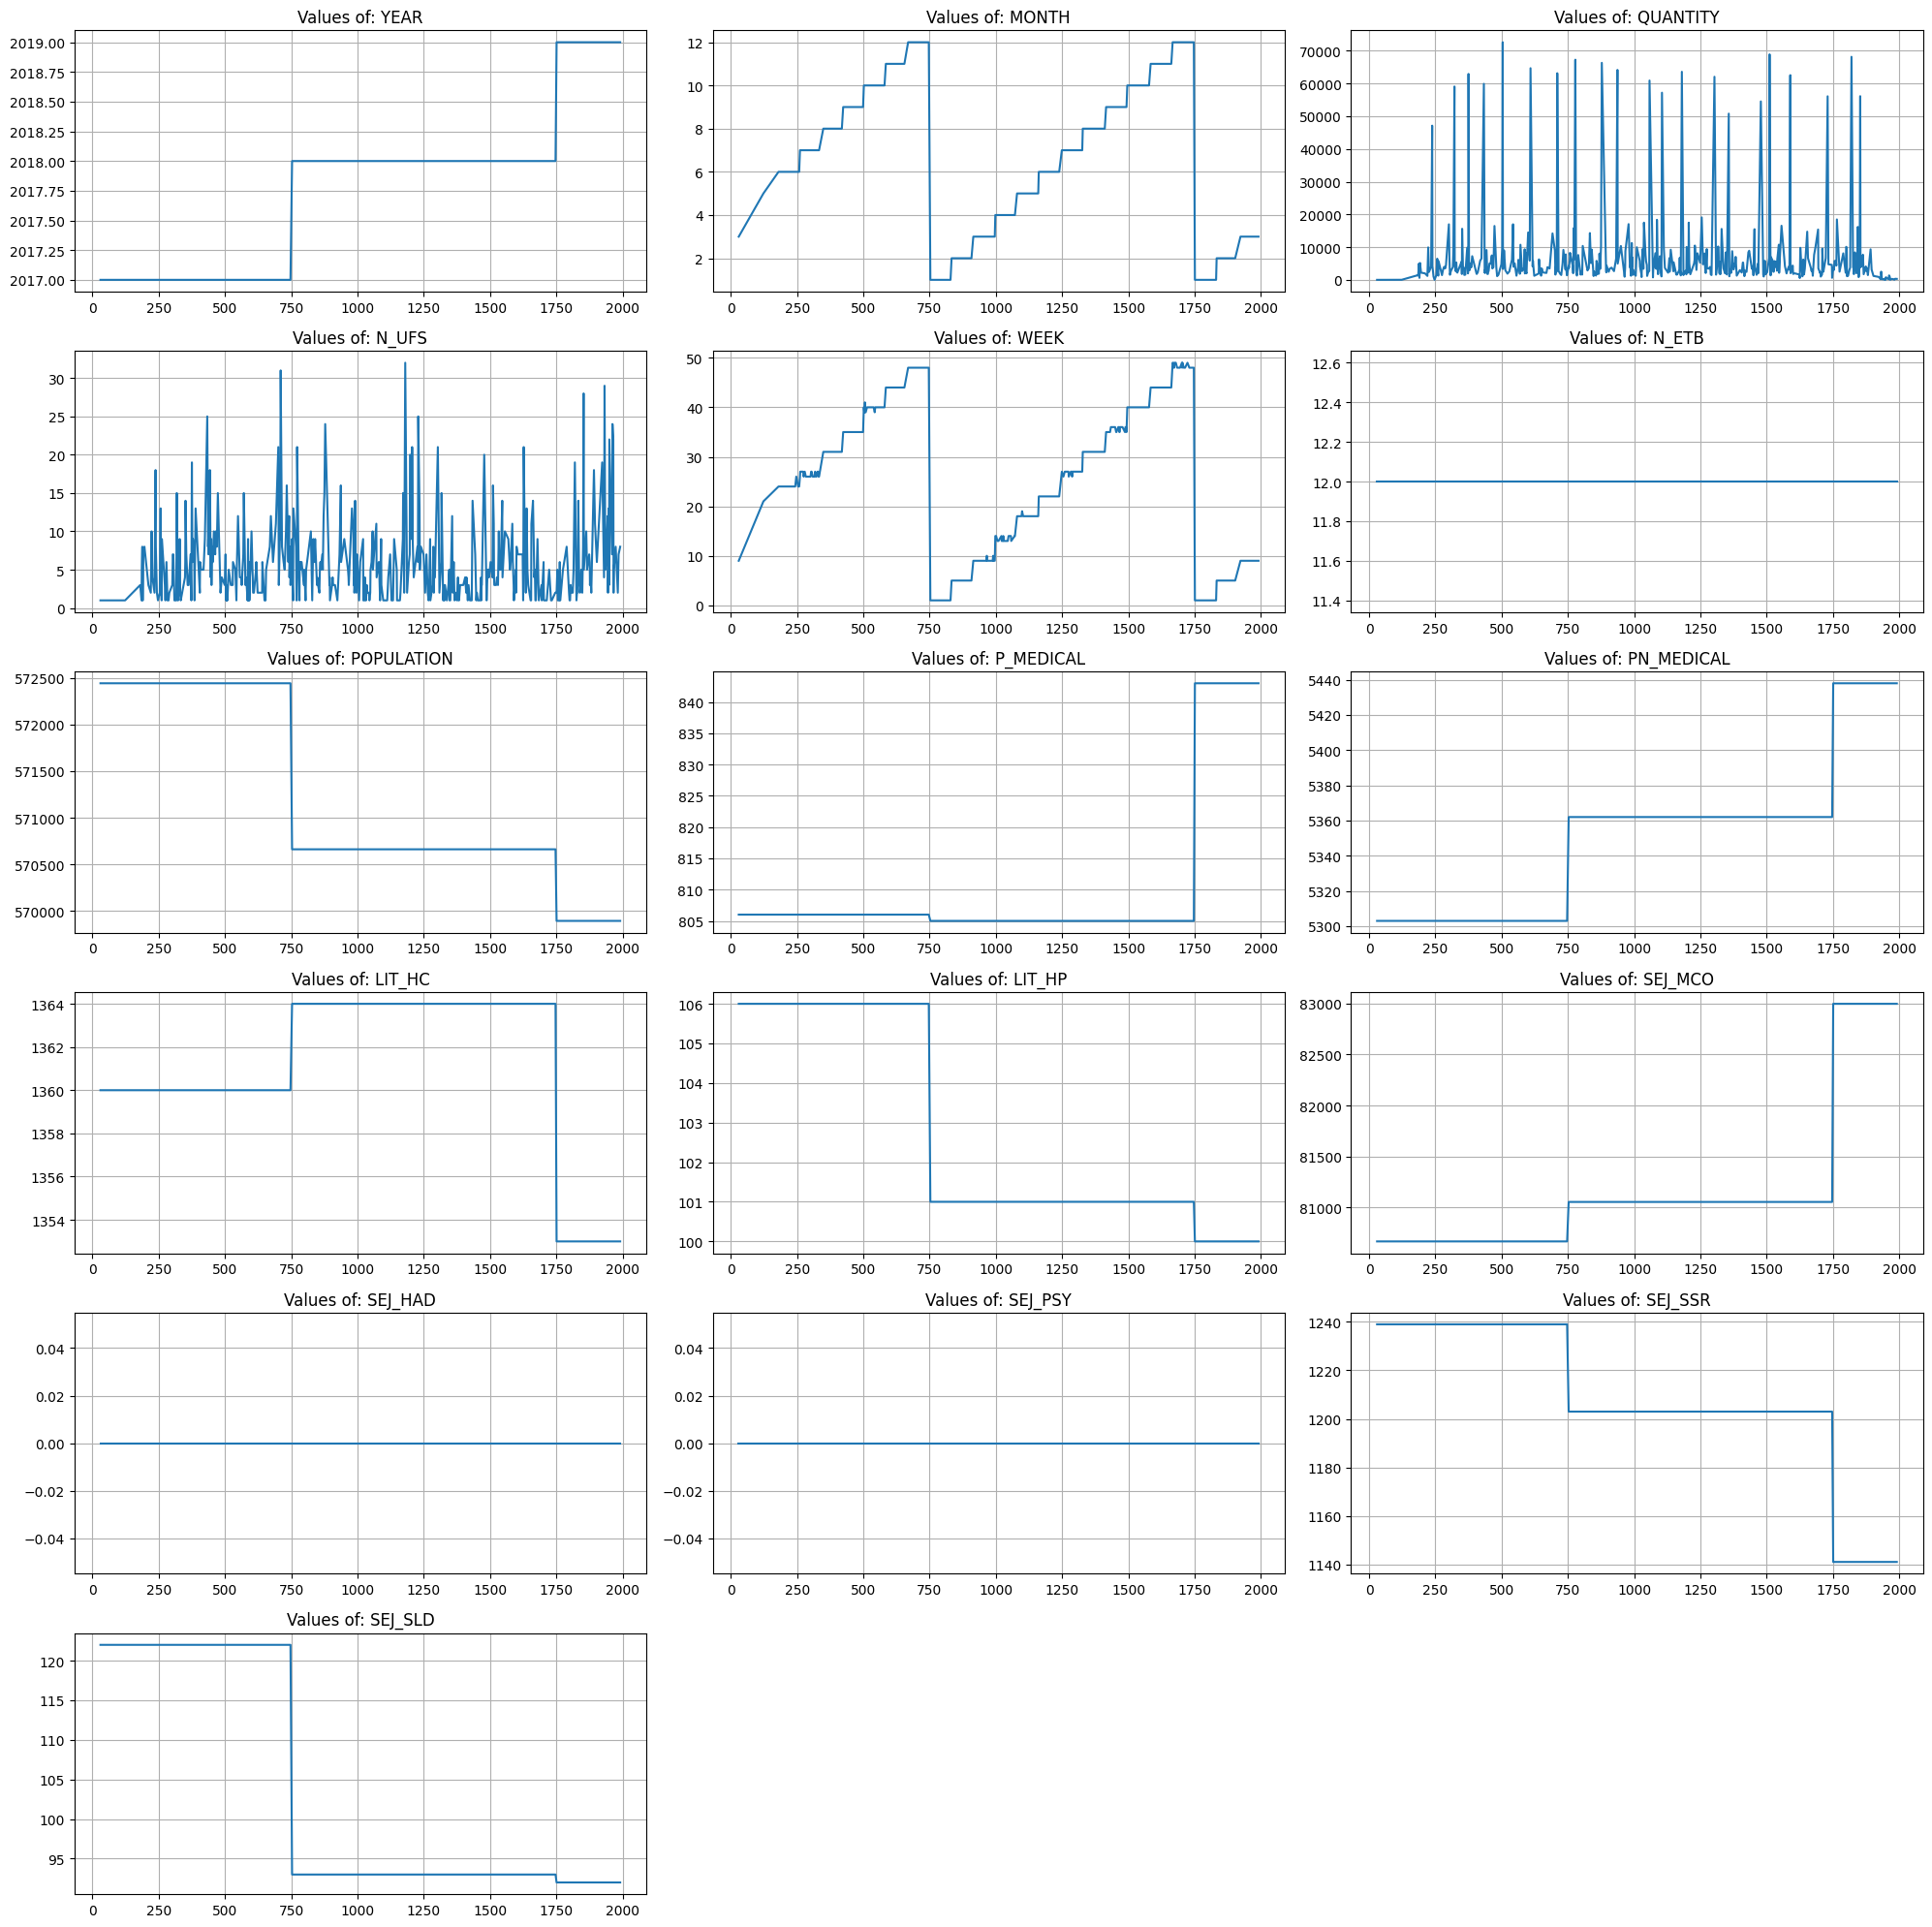

In [12]:
# Visualizing values of numerical features
plot_df(df_h1)

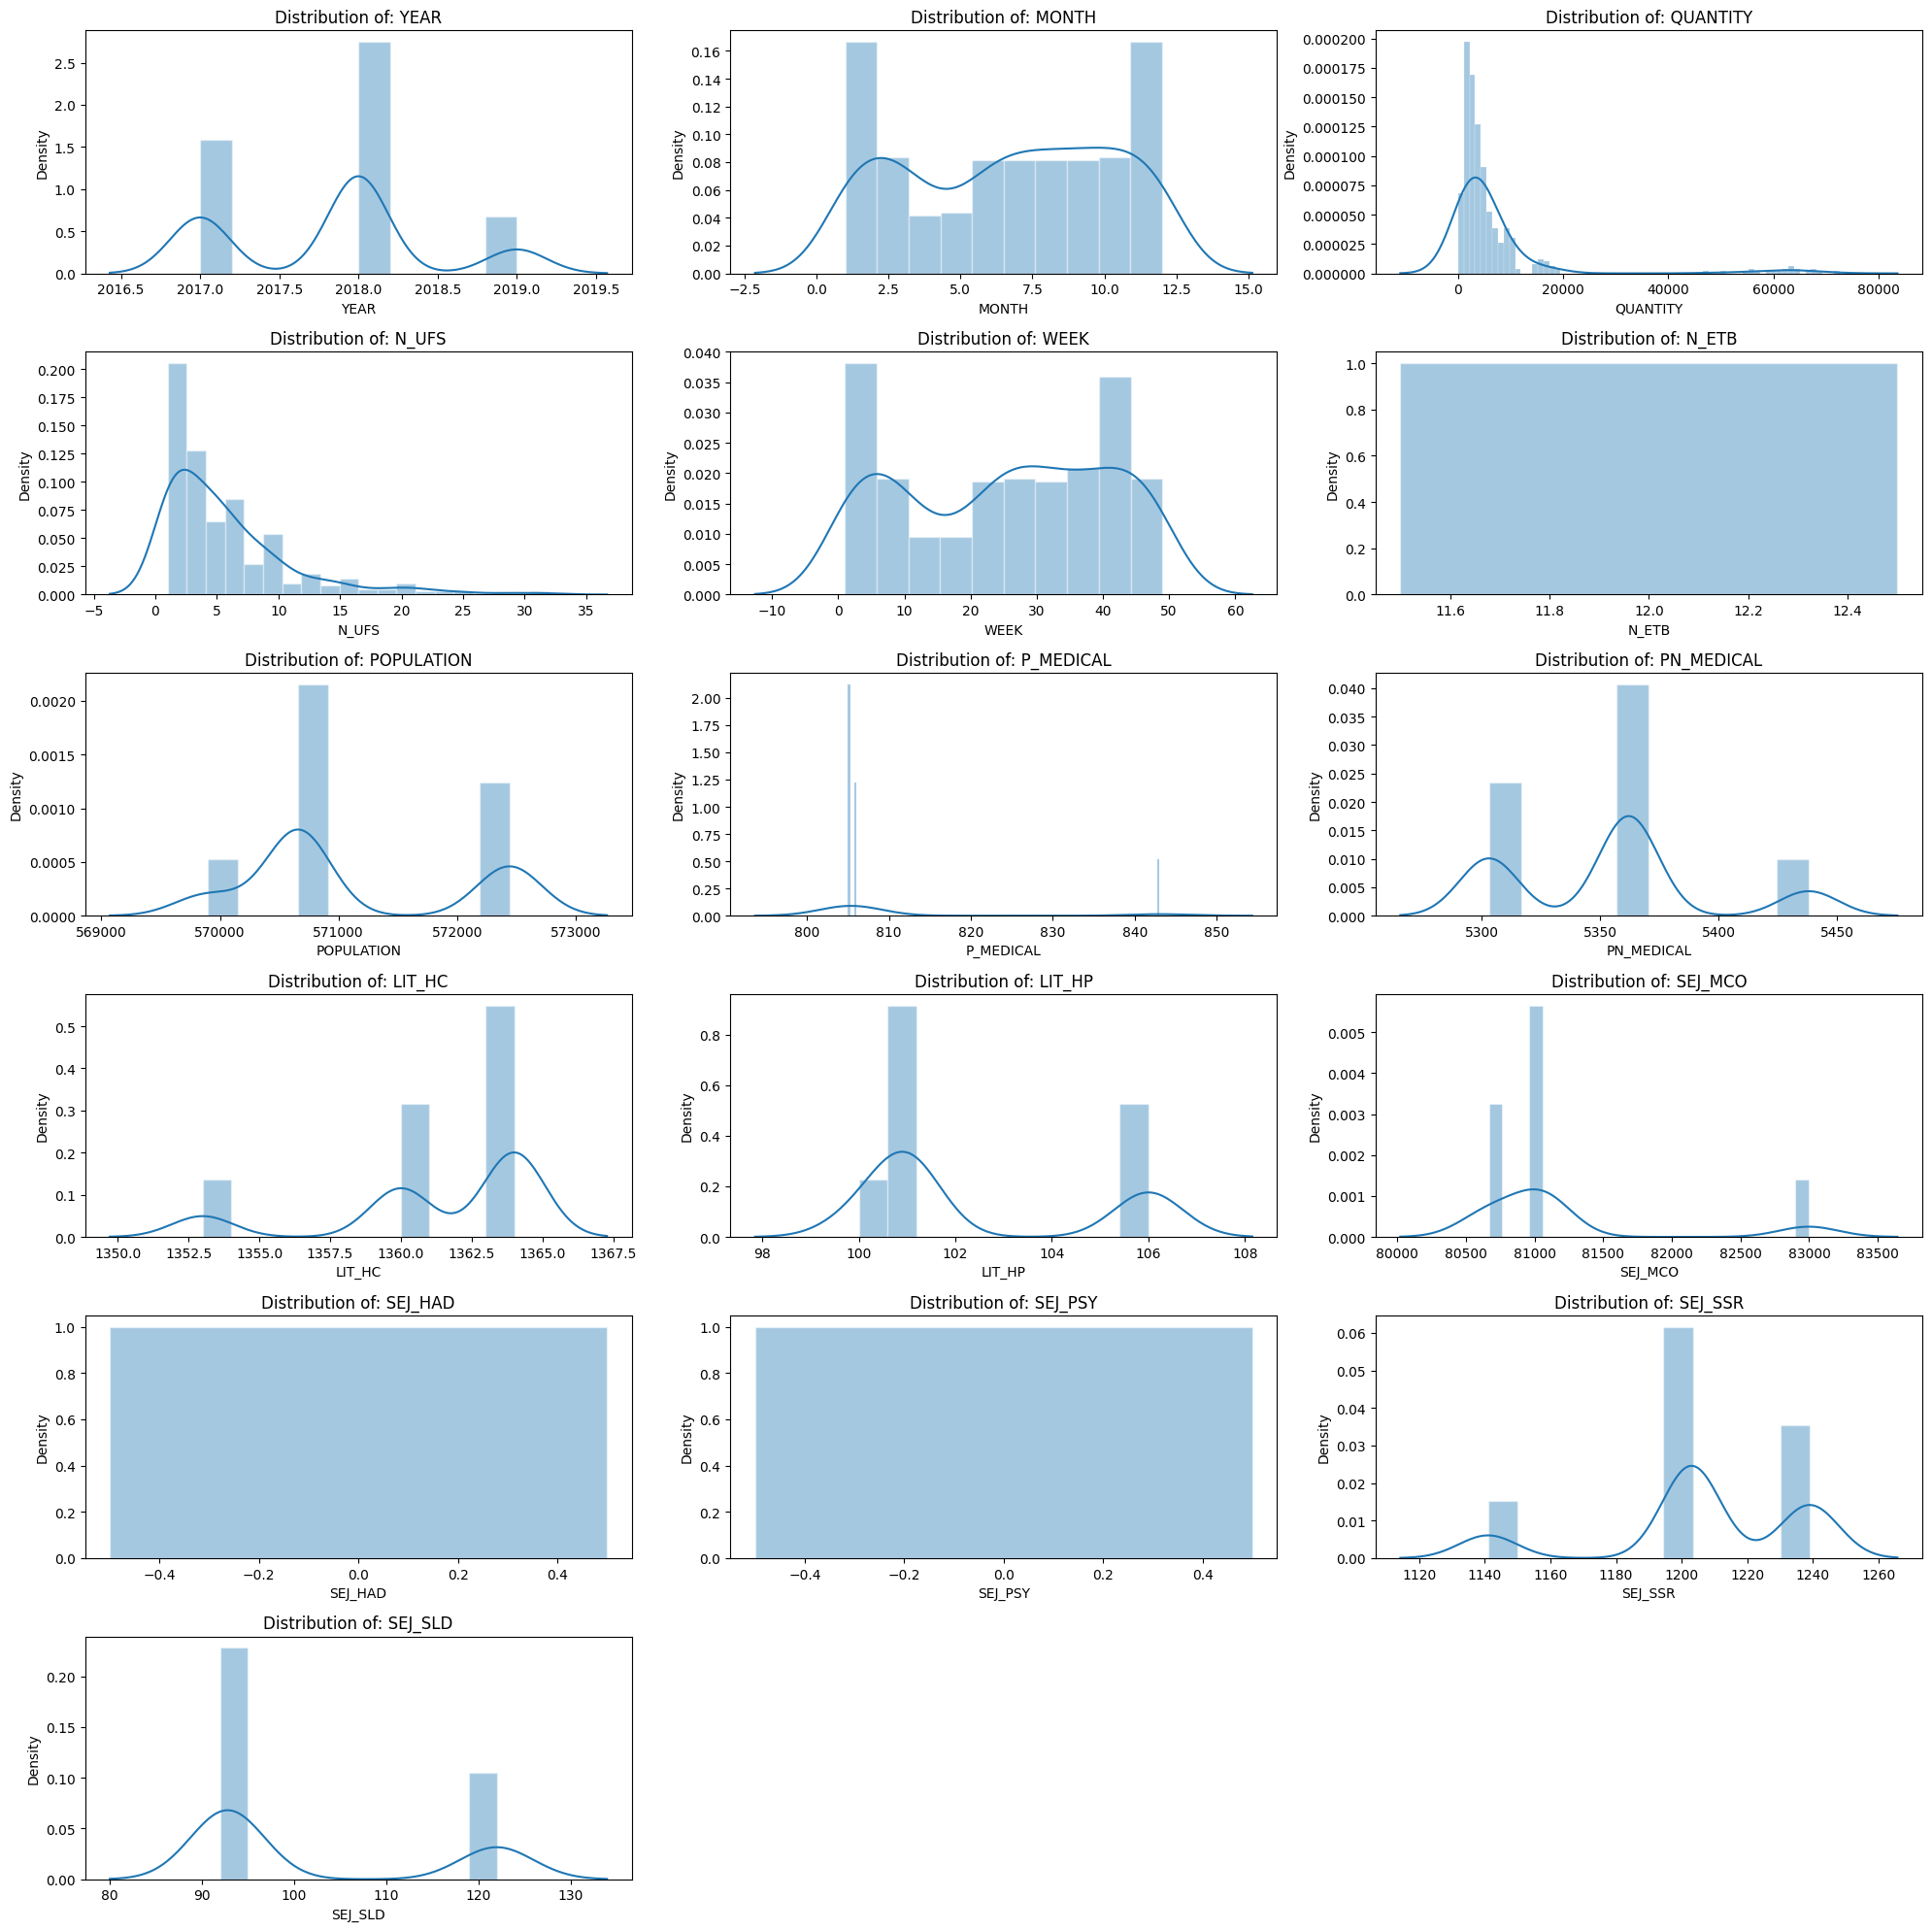

In [13]:
visualize_distribution(df_h1)

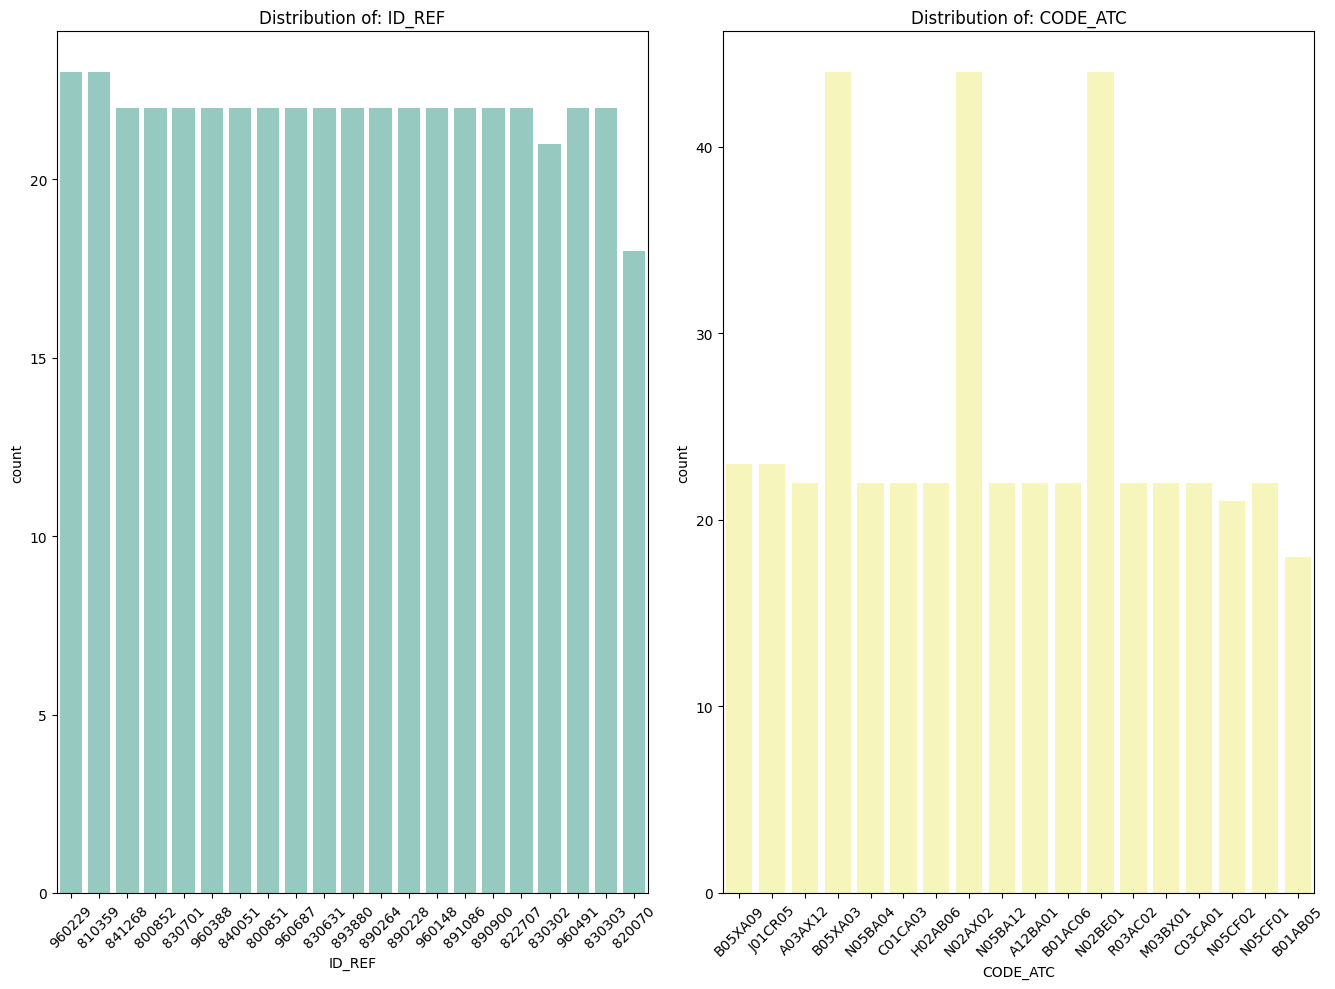

In [14]:
# Question to be asked:  As ID_REF and HOSPI_CODE_UCD are the same information, can we eliminate one column?
# Other question is why the pattern between the two variables are the similar, they are explaining the same thing?

visualize_distribution(df_h1, data_type='categorical')

## 2.4 - Transforming categorical features

In [44]:
# Select the columns to be encoded
columns_to_encode = ['ID_REF', 'CODE_ATC']

# Fill missing values in the columns to be encoded with a placeholder value
df_h1_filled = df_h1[columns_to_encode].fillna('NA')

# Perform one-hot encoding using pandas' get_dummies function
encoded_df = pd.get_dummies(df_h1_filled)

# Merge the encoded columns back with the original DataFrame
df_h1_onehot = pd.concat([df_h1.drop(columns_to_encode, axis=1), encoded_df], axis=1)

# Display the information about the new DataFrame
df_h1_onehot


,YEAR,MONTH,QUANTITY,N_UFS,WEEK,N_ETB,POPULATION,P_MEDICAL,PN_MEDICAL,LIT_HC,...,CODE_ATC_H02AB06,CODE_ATC_J01CR05,CODE_ATC_M03BX01,CODE_ATC_N02AX02,CODE_ATC_N02BE01,CODE_ATC_N05BA04,CODE_ATC_N05BA12,CODE_ATC_N05CF01,CODE_ATC_N05CF02,CODE_ATC_R03AC02
30,2017,3,1.0,1,9.0,12,572443.0,806,5303,1360.0,...,0,0,0,0,0,0,0,0,0,0
123,2017,5,20.0,1,21.0,12,572443.0,806,5303,1360.0,...,0,1,0,0,0,0,0,0,0,0
180,2017,6,1335.0,3,24.0,12,572443.0,806,5303,1360.0,...,0,0,0,0,0,0,0,0,0,0
185,2017,6,1330.0,1,24.0,12,572443.0,806,5303,1360.0,...,0,0,0,0,0,0,0,0,0,0
186,2017,6,2265.0,5,24.0,12,572443.0,806,5303,1360.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974,2019,3,300.0,8,9.0,12,569894.0,843,5438,1353.0,...,0,0,0,0,0,0,0,0,0,0
1982,2019,3,40.0,2,9.0,12,569894.0,843,5438,1353.0,...,0,0,0,0,0,0,0,0,0,0
1984,2019,3,250.0,5,9.0,12,569894.0,843,5438,1353.0,...,0,0,0,0,0,0,0,0,0,0
1985,2019,3,330.0,7,9.0,12,569894.0,843,5438,1353.0,...,0,0,0,0,0,1,0,0,0,0


# 3 - Feature manipulation and comprehension

## 3.1 - Correlation analysis

<Axes: >

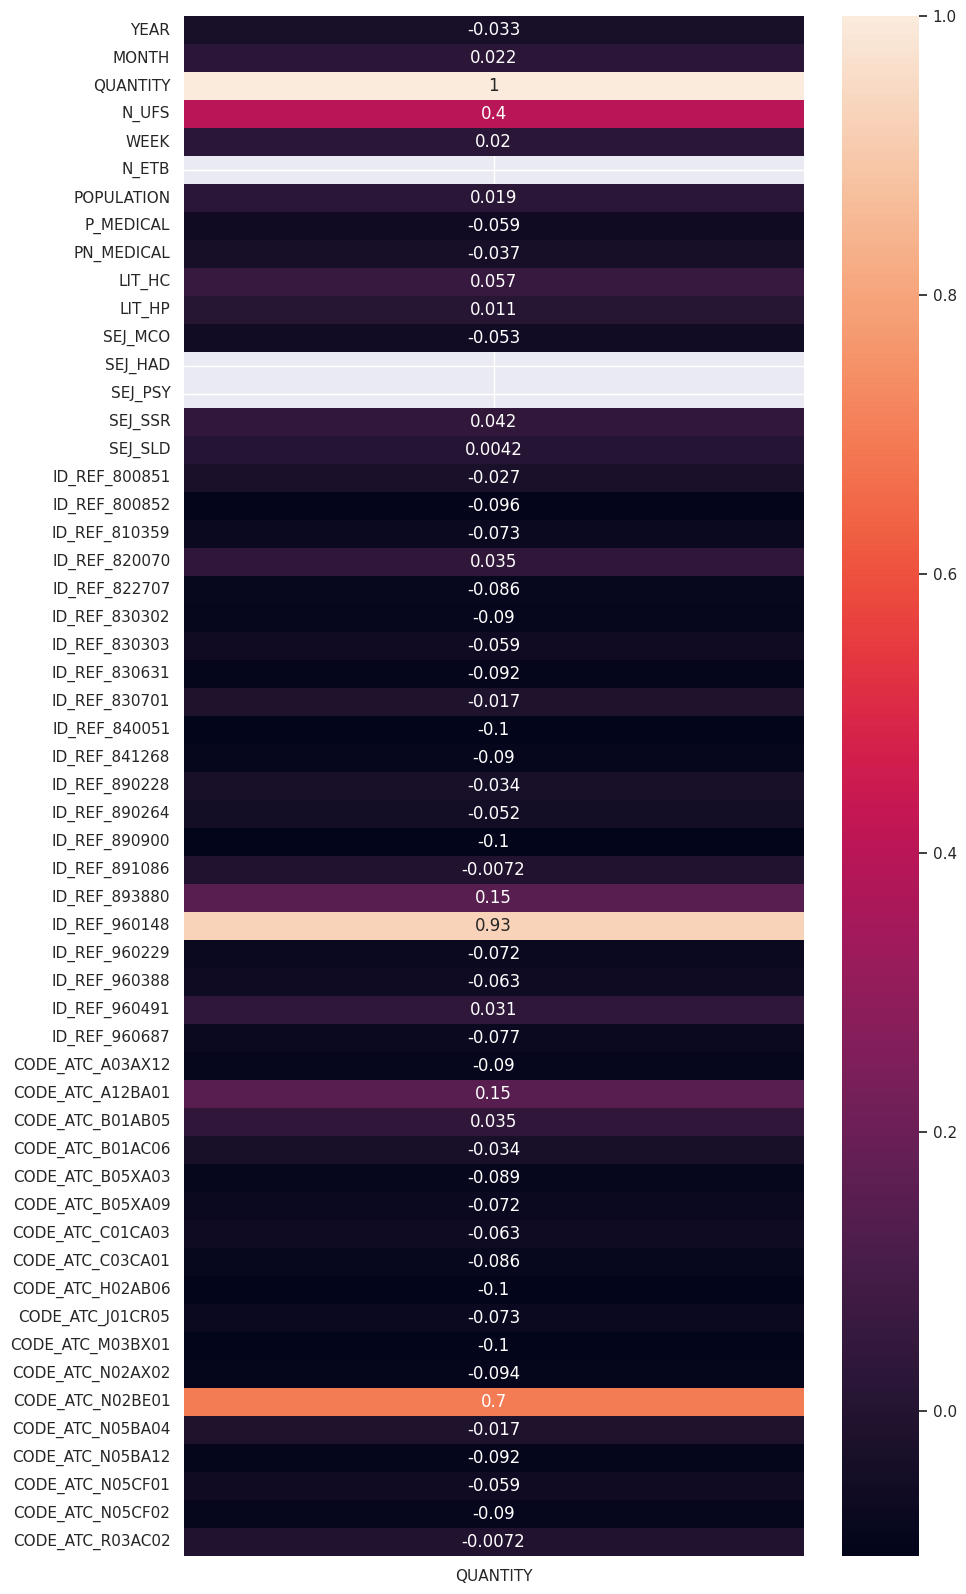

In [16]:
corr = df_h1_onehot.corr(numeric_only=True)
x = corr[['QUANTITY']]
sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(x,annot=True)

<Axes: >

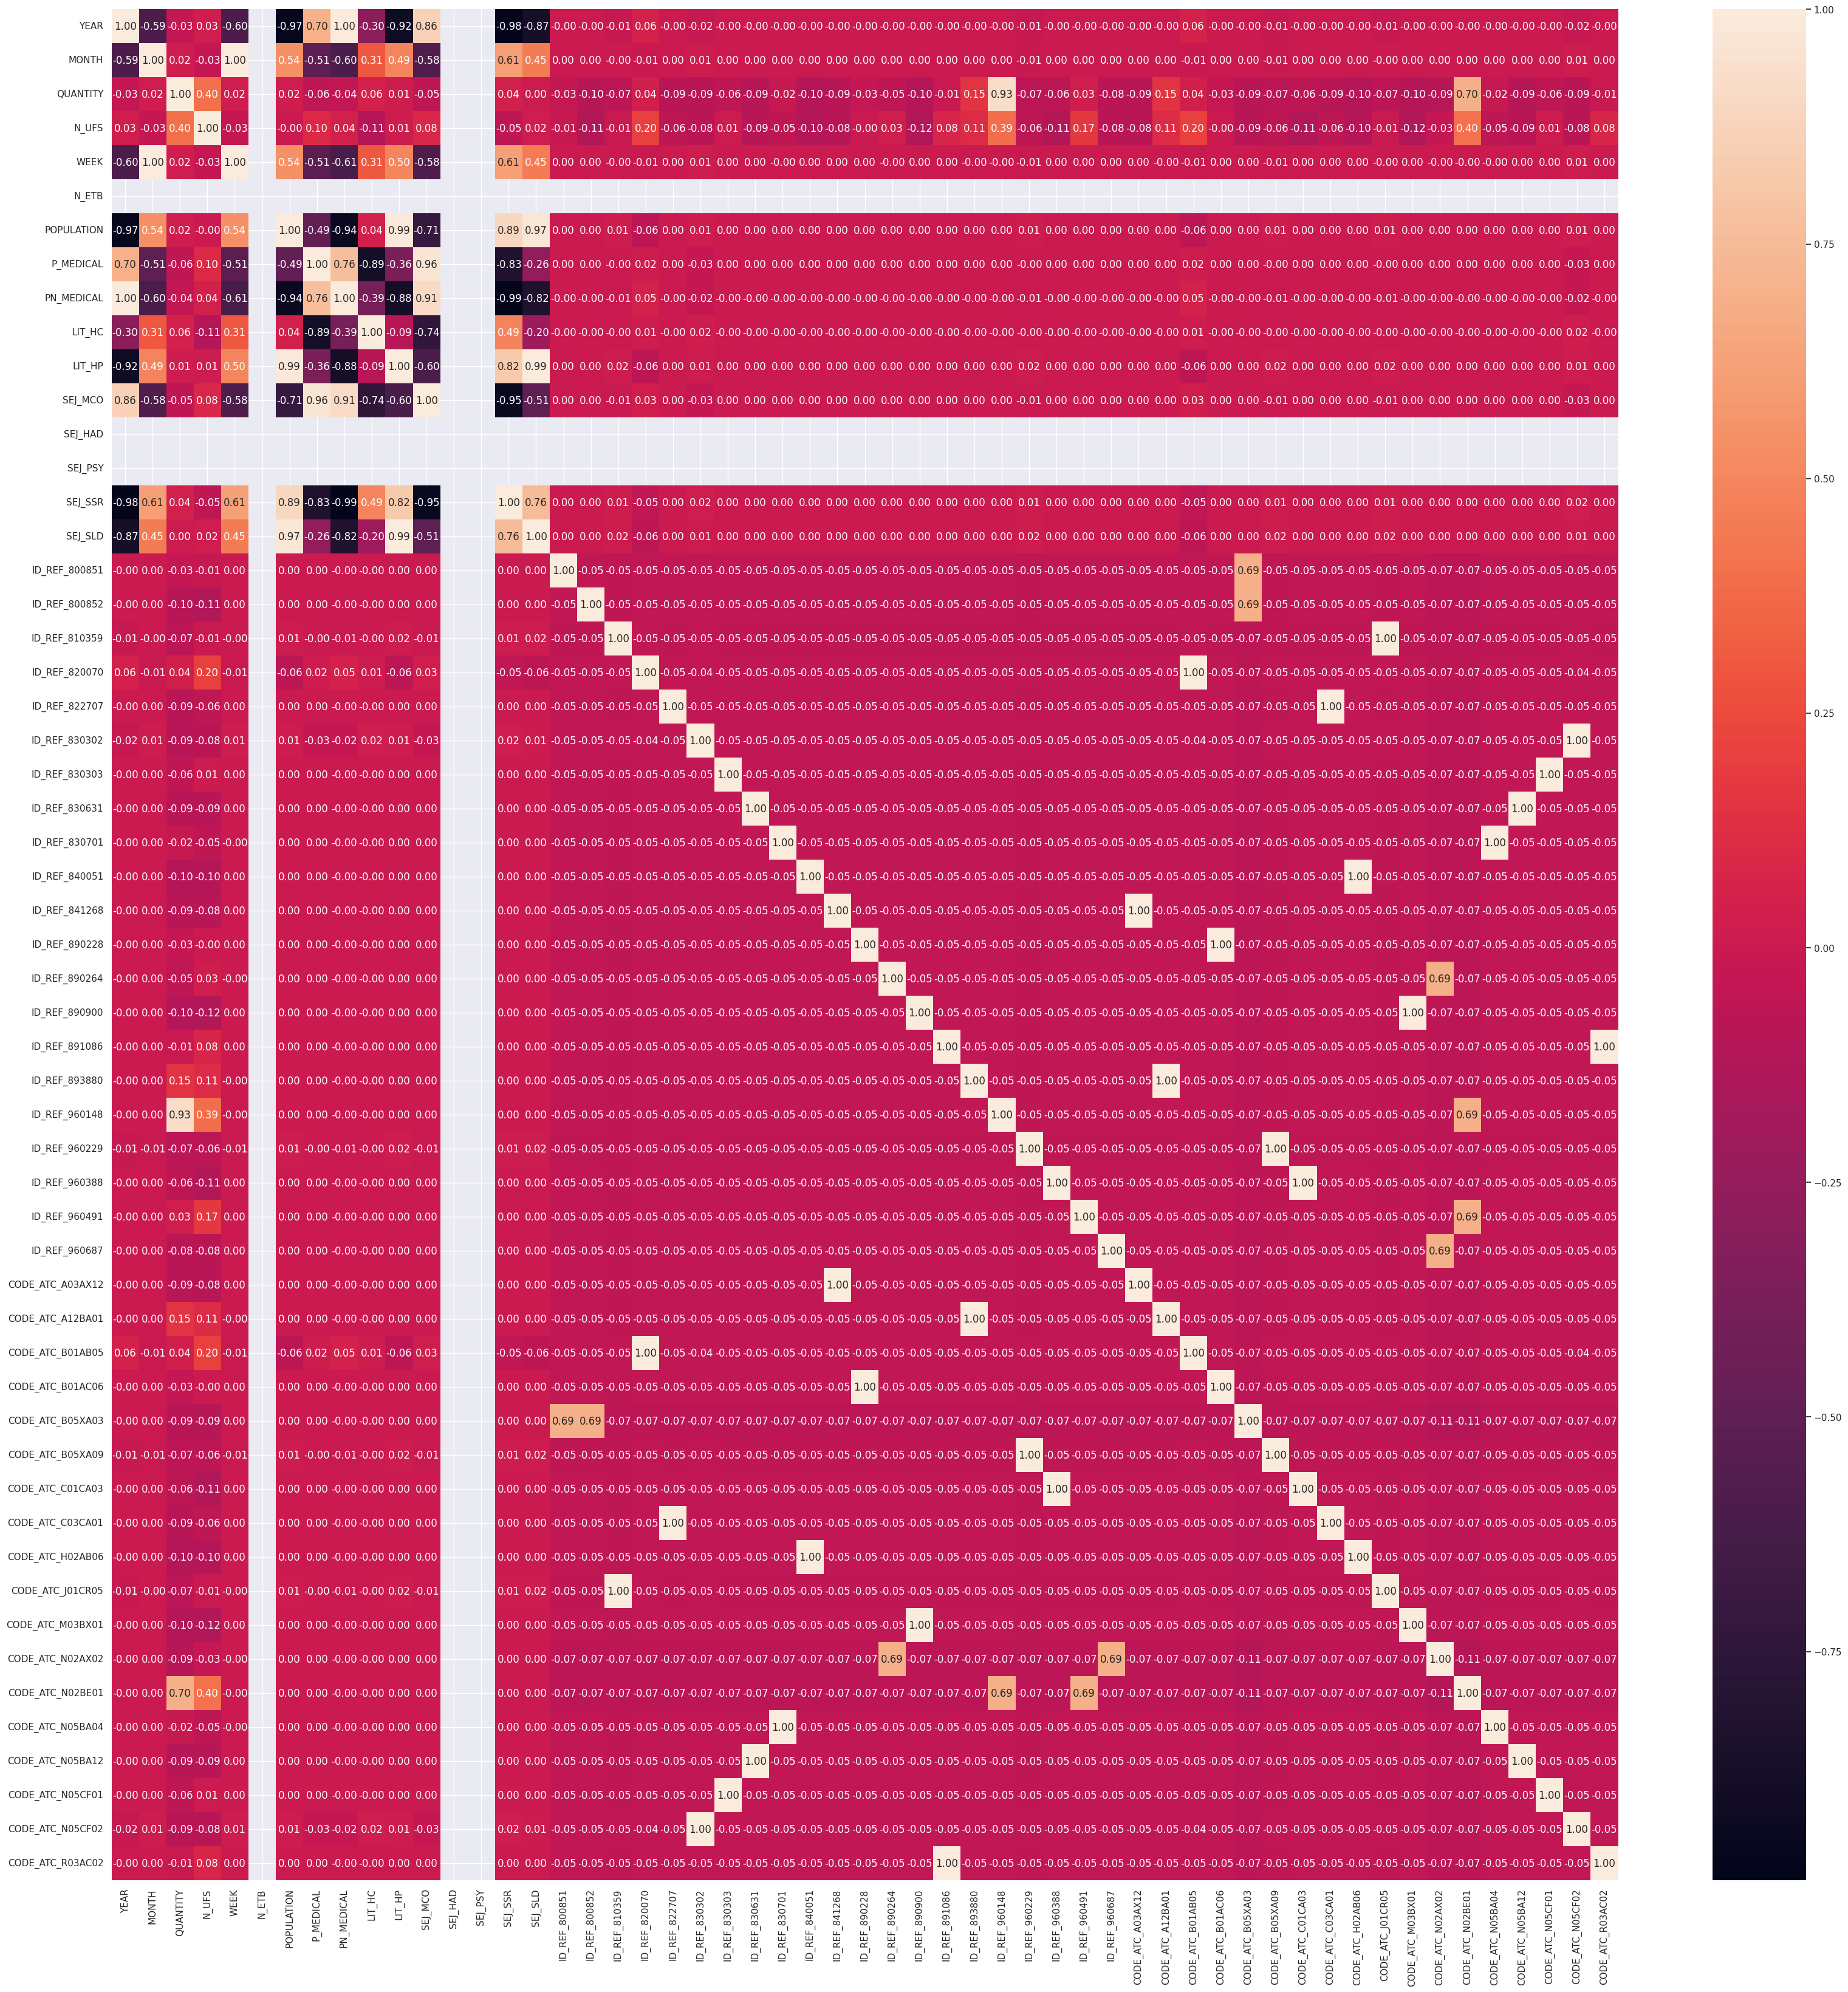

In [17]:
'''
  The constant values are not displayed in the correlation.
'''

corr = df_h1_onehot.corr(numeric_only=True)
sns.set(rc={'figure.figsize': (40, 40)})
sns.heatmap(corr, annot=True, fmt='.2f')


## 3.2 - Normalize / Scale data

In [18]:
df_h1_numerical = df_h1_onehot.copy()
df_h1_numerical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 459 entries, 30 to 1991
Data columns (total 55 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   YEAR              459 non-null    int64  
 1   MONTH             459 non-null    int64  
 2   QUANTITY          459 non-null    float64
 3   N_UFS             459 non-null    int64  
 4   WEEK              459 non-null    float64
 5   N_ETB             459 non-null    int64  
 6   POPULATION        459 non-null    float64
 7   P_MEDICAL         459 non-null    int64  
 8   PN_MEDICAL        459 non-null    int64  
 9   LIT_HC            459 non-null    float64
 10  LIT_HP            459 non-null    float64
 11  SEJ_MCO           459 non-null    int64  
 12  SEJ_HAD           459 non-null    int64  
 13  SEJ_PSY           459 non-null    int64  
 14  SEJ_SSR           459 non-null    int64  
 15  SEJ_SLD           459 non-null    int64  
 16  ID_REF_800851     459 non-null    uint8  


### Standardize the features

In [19]:
# Normalizing data
X = df_h1_numerical.values
X.shape

(459, 55)

In [20]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

## 3.3 - Dimensionality reduction with PCA

Principal component analysis (PCA).

Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space.


In Scikit-learn, [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) is applied using the PCA() class. It is in the decomposition submodule in Scikit-learn. The most important hyperparameter in that class is n_components.


The construction of relevant features is achieved by linearly transforming correlated variables into a smaller number of uncorrelated variables. This is done by projecting (dot product) the original data into the reduced PCA space using the eigenvectors of the covariance/correlation matrix aka the principal components (PCs). [[towards dqtqscience](https://towardsdatascience.com/pca-clearly-explained-how-when-why-to-use-it-and-feature-importance-a-guide-in-python-7c274582c37e)]


In [21]:
pca_19 = PCA(n_components = X.shape[1], random_state = 42)
pca_19.fit(X_scaled)
X_pca_19 = pca_19.transform(X_scaled)

In [22]:
print(f"Variance explained by all 19 principal components: {sum(pca_19.explained_variance_ratio_ * 100):.2f}")

Variance explained by all 19 principal components: 100.00


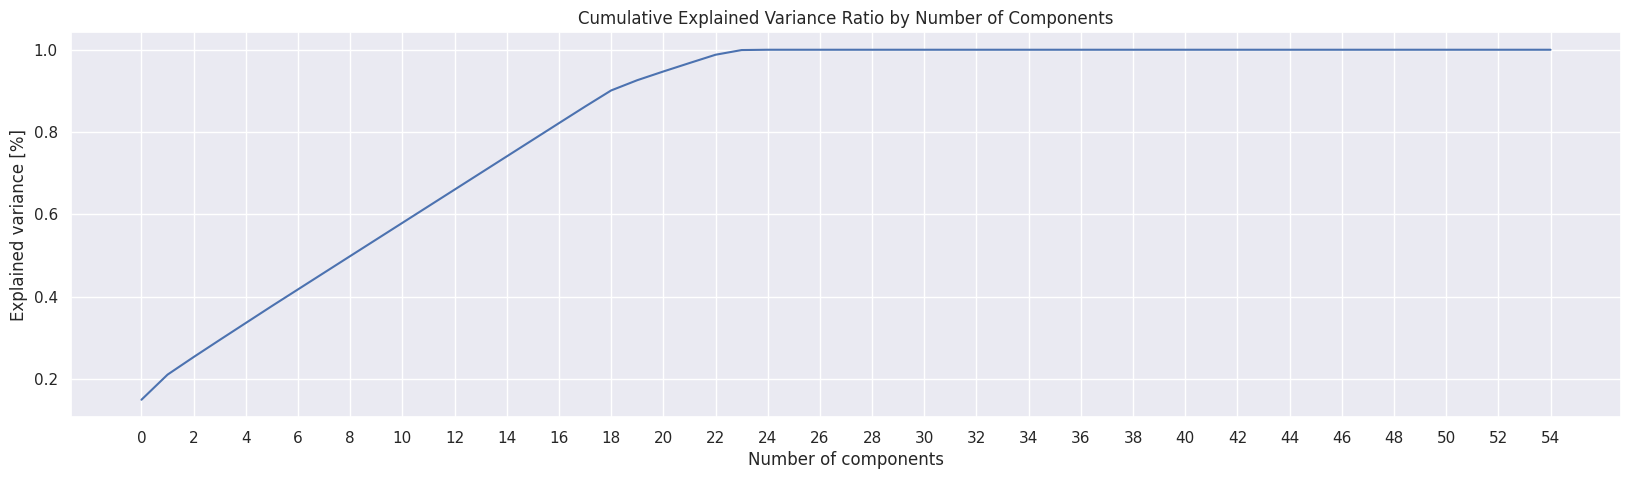

In [23]:
'''
  We can notice here that the first 6 components keep 99% of the variability
  in the dataset while reducing 12 features in the dataset.
'''

cumsum_X = np.cumsum(pca_19.explained_variance_ratio_)

# Set the figure size to 12 by 12
plt.figure(figsize=(20, 5))

plt.plot(cumsum_X)
plt.xlabel('Number of components')
plt.ylabel('Explained variance [%]')

# Set the tick locations and labels
tick_locations = np.arange(0, len(cumsum_X), 2)
tick_labels = np.arange(0, len(cumsum_X), 2, dtype=int)
plt.xticks(tick_locations, tick_labels)

plt.title("Cumulative Explained Variance Ratio by Number of Components")

plt.show()


### PCA 95

Let’s apply PCA to our dataset with n_components=0.95. This will select the number of components while preserving 95% of the variability in the data. The retrieved shape was (459,7), which means that the algorithm has found 7 principal components to preserve 95% of the variability in the data.

In [24]:

'''
  pca_95.get_params(deep=True)
  {'copy': True,
  'iterated_power': 'auto',
  'n_components': 0.95,
  'n_oversamples': 10,
  'power_iteration_normalizer': 'auto',
  'random_state': 42,
  'svd_solver': 'auto',
  'tol': 0.0,
  'whiten': False}

'''
pca_95 = PCA(n_components = 0.95, random_state = 42)
pca_95.fit(X_scaled)
X_pca_95 = pca_95.transform(X_scaled)
X_pca_95.shape

(459, 22)

In [25]:
df_h1_reduced = pd.DataFrame(X_pca_95,
                             columns = ['PC01','PC02','PC03','PC04','PC05',
                                        'PC06','PC07','PC08','PC09','PC10',
                                        'PC11','PC12','PC13','PC14','PC15',
                                        'PC16','PC17','PC18','PC19','PC20',
                                        'PC21','PC22'])
df_h1_reduced.head()

,PC01,PC02,PC03,PC04,PC05,PC06,PC07,PC08,PC09,PC10,...,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22
0,-2.386026,-1.083212,-2.445741,-0.099210,-1.062497,-0.040730,4.415918,-3.384587,2.001408,0.103898,...,-1.514194e-12,2.536808e-13,2.143506e-13,-1.737107e-14,-2.409840e-13,-0.718293,-0.398495,-0.194419,2.115810,0.001325
1,-2.733317,-0.911877,-2.416194,0.882116,-1.088034,1.761838,-3.916432,-0.801010,3.683371,0.076433,...,8.603784e-13,6.191940e-13,4.532429e-13,-5.328678e-14,1.475525e-13,-0.120784,-1.131226,-0.166579,1.318570,-0.108874
2,-2.809329,-1.045360,-1.196035,-0.312588,-0.877734,-0.611163,-0.458323,0.044538,-0.944960,-0.806791,...,7.098860e-01,-1.225752e+00,-3.163462e+00,-2.648873e+00,3.427615e+00,-0.585994,0.943986,-0.251489,1.132483,0.039796
3,-2.817430,-1.116230,-1.177254,-2.842127,2.843518,1.930361,0.018986,-0.011005,-0.031988,-0.003192,...,3.244576e-15,1.240159e-14,1.156838e-14,-9.952795e-16,-1.419316e-14,-0.020742,0.792203,0.064383,1.260761,-2.054250
4,-2.840601,-0.717218,-2.305716,-0.018852,-1.052002,0.050251,4.408413,-3.373738,1.978666,0.106863,...,-1.508865e-12,2.418014e-13,2.044974e-13,-1.412367e-14,-2.478951e-13,-0.767189,-0.367828,-0.183573,0.917459,0.065545


# 4 - Clustering

## 4.1 - Train, test split

In [26]:
X_train, X_test = train_test_split(df_h1_reduced.values, test_size = 0.3, random_state=42)

## 4.2 - K-means different models and 4.3 - Model evaluation



In [27]:
min_clusters = 2
max_clusters = len(df_h1.ID_REF.unique())

s_scores = np.zeros(max_clusters-1)
dbs_scores = np.zeros(max_clusters-1)
calinski_scores = np.zeros(max_clusters-1)

clusters = range(2, max_clusters + 1)

for n_clusters in clusters:

  s_scores[n_clusters-2], dbs_scores[n_clusters-2], calinski_scores[n_clusters-2] =  evaluate_kmeans_clustering(X_train, X_test, n_clusters)

---------------------------------------------------------------------
---------------------------------------------------------------------

########## Metrics best performance for different clusters ##########
Best score for Silhouette metric: 0.47 for 21 clusters
Best score for Davies Bouldin metric: 0.86 for 21 clusters
Best score for Calinski metric: 22.61 for 2 clusters

---------------------------------------------------------------------
---------------------------------------------------------------------



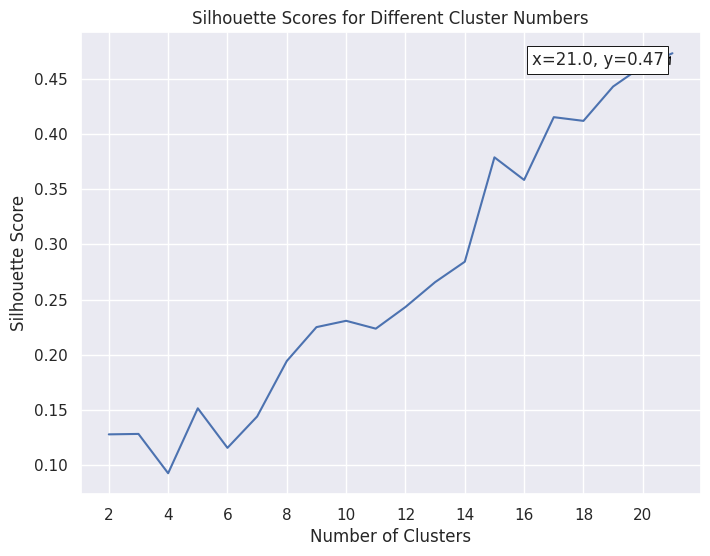

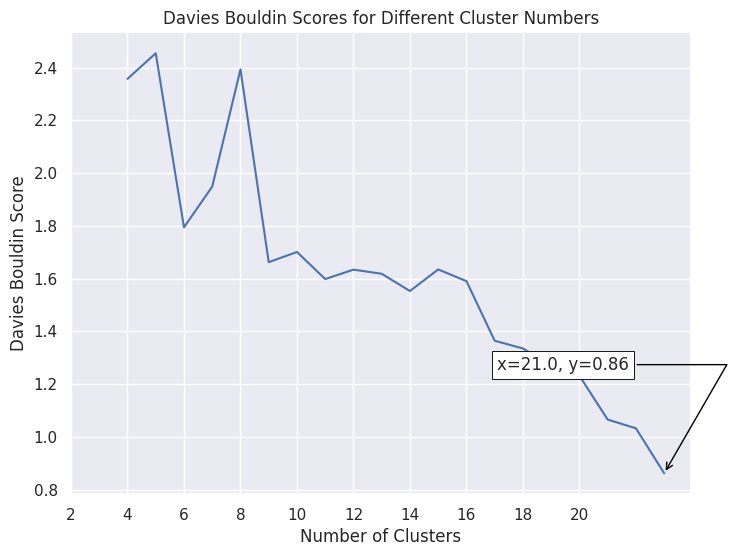

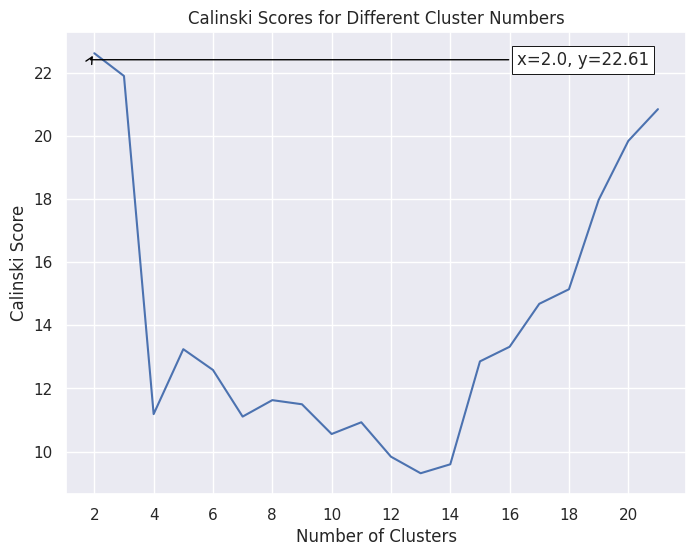

In [28]:
visualize_kmeans_clustering_metrics(min_clusters, max_clusters, s_scores, dbs_scores, calinski_scores)

## 4.2 - Testing without PCA

In [29]:
X_train, X_test = train_test_split(df_h1_numerical.values, test_size = 0.3, random_state=42)



min_clusters = 2
max_clusters = len(df_h1.ID_REF.unique())

s_scores = np.zeros(max_clusters-1)
dbs_scores = np.zeros(max_clusters-1)
calinski_scores = np.zeros(max_clusters-1)

clusters = range(2, max_clusters + 1)

for n_clusters in clusters:

  s_scores[n_clusters-2], dbs_scores[n_clusters-2], calinski_scores[n_clusters-2] =  evaluate_kmeans_clustering(X_train, X_test, n_clusters)

---------------------------------------------------------------------
---------------------------------------------------------------------

########## Metrics best performance for different clusters ##########
Best score for Silhouette metric: 0.91 for 2 clusters
Best score for Davies Bouldin metric: 0.17 for 2 clusters
Best score for Calinski metric: 1395.64 for 14 clusters

---------------------------------------------------------------------
---------------------------------------------------------------------



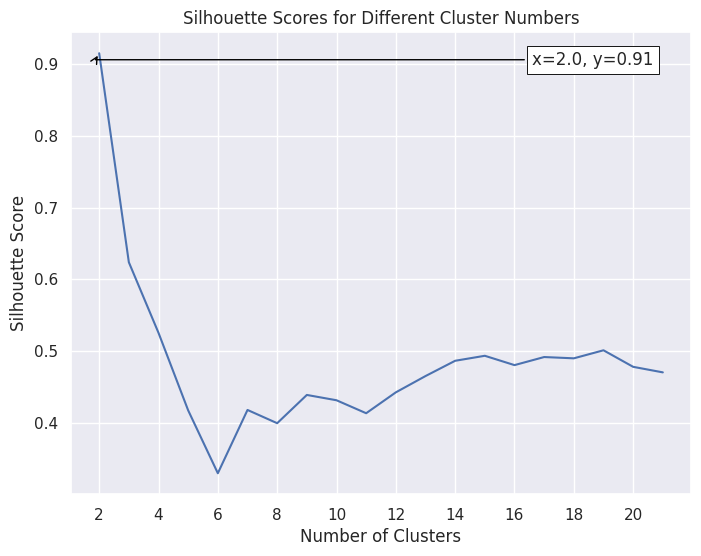

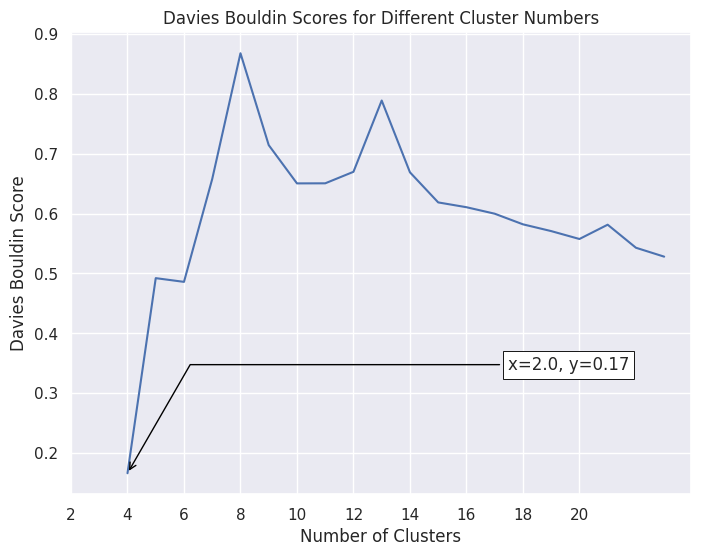

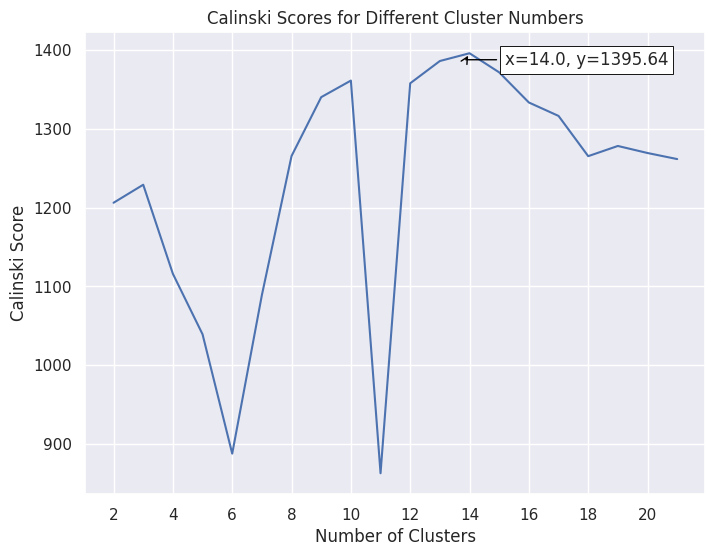

In [30]:
visualize_kmeans_clustering_metrics(min_clusters, max_clusters, s_scores, dbs_scores, calinski_scores)

In [31]:
values = df_h1_numerical.values
model = kmeans_clustering(values, n_clusters = 2)
labels  = model.fit_predict(values)
df_h1['cluster'] = labels

In [32]:
description = df_h1.groupby("cluster")["QUANTITY", "POPULATION", "P_MEDICAL", "PN_MEDICAL"]
n_drugs = description.size()
description = description.mean()
description['n_drugs'] = n_drugs
description



<ipython-input-32-5120992be857>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  description = df_h1.groupby("cluster")["QUANTITY", "POPULATION", "P_MEDICAL", "PN_MEDICAL"]


,QUANTITY,POPULATION,P_MEDICAL,PN_MEDICAL,n_drugs
cluster,,,,,
0,4398.294521,571117.931507,810.520548,5353.821918,438
1,61328.523810,571182.523810,808.952381,5349.571429,21


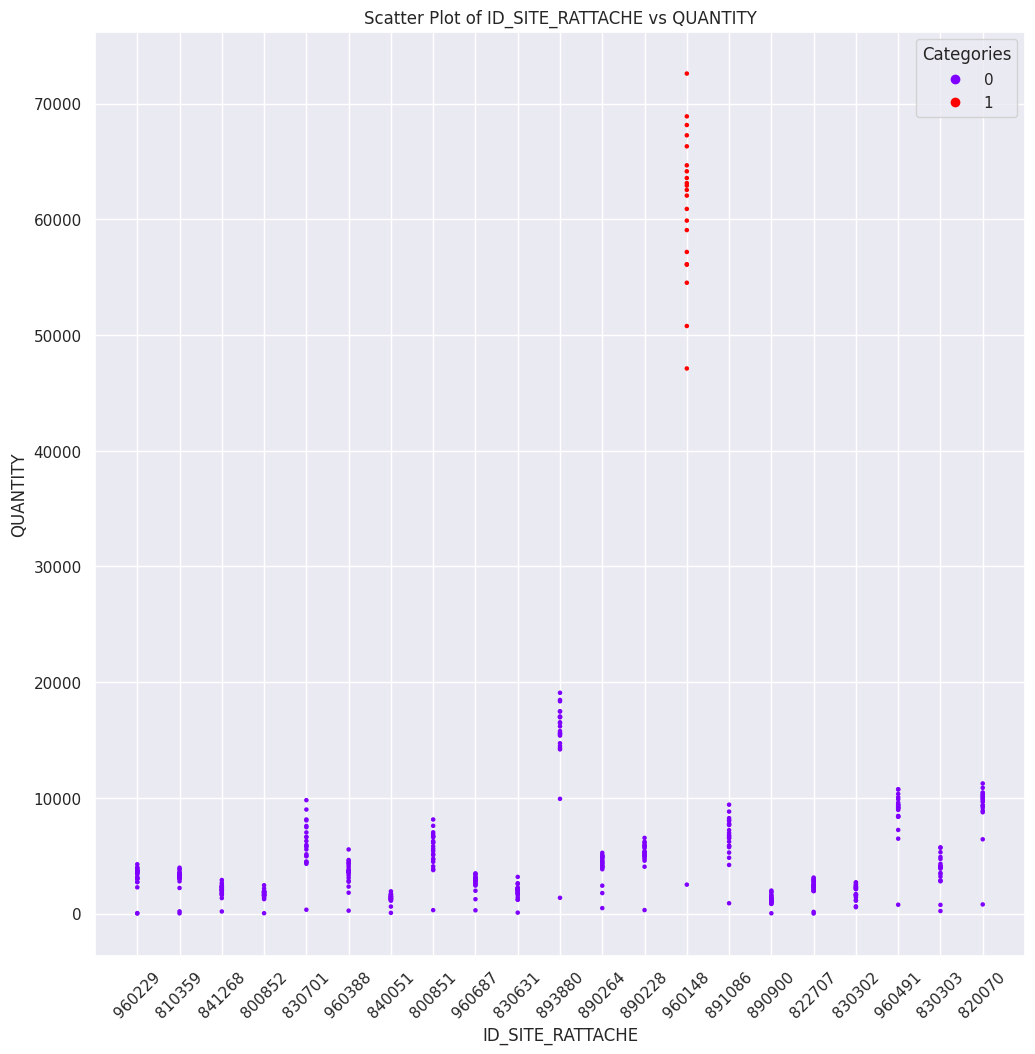

In [33]:
plt.figure(figsize=(12, 12))
scatter = plt.scatter(df_h1["ID_REF"], df_h1["QUANTITY"], c=labels, s=5, cmap='rainbow')
plt.xlabel("ID_SITE_RATTACHE")
plt.ylabel("QUANTITY")
plt.title("Scatter Plot of ID_SITE_RATTACHE vs QUANTITY")
plt.xticks(rotation=45)
plt.legend(handles=scatter.legend_elements()[0], labels=scatter.legend_elements()[1], title="Categories")
plt.show()


# 5 - Prediction

## 5.1 - New database composition based on clusters

In [35]:
df_h1_c0 = df_h1[df_h1['cluster'] == 0].copy()
df_h1_c1 = df_h1[df_h1['cluster'] == 1].copy()

In [36]:
df_h1_c0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438 entries, 30 to 1991
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID_REF      438 non-null    string 
 1   YEAR        438 non-null    int64  
 2   MONTH       438 non-null    int64  
 3   QUANTITY    438 non-null    float64
 4   CODE_ATC    438 non-null    string 
 5   N_UFS       438 non-null    int64  
 6   WEEK        438 non-null    float64
 7   N_ETB       438 non-null    int64  
 8   POPULATION  438 non-null    float64
 9   P_MEDICAL   438 non-null    int64  
 10  PN_MEDICAL  438 non-null    int64  
 11  LIT_HC      438 non-null    float64
 12  LIT_HP      438 non-null    float64
 13  SEJ_MCO     438 non-null    int64  
 14  SEJ_HAD     438 non-null    int64  
 15  SEJ_PSY     438 non-null    int64  
 16  SEJ_SSR     438 non-null    int64  
 17  SEJ_SLD     438 non-null    int64  
 18  cluster     438 non-null    int32  
dtypes: float64(5), int32(1), in

In [37]:
df_h1_c1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 238 to 1853
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID_REF      21 non-null     string 
 1   YEAR        21 non-null     int64  
 2   MONTH       21 non-null     int64  
 3   QUANTITY    21 non-null     float64
 4   CODE_ATC    21 non-null     string 
 5   N_UFS       21 non-null     int64  
 6   WEEK        21 non-null     float64
 7   N_ETB       21 non-null     int64  
 8   POPULATION  21 non-null     float64
 9   P_MEDICAL   21 non-null     int64  
 10  PN_MEDICAL  21 non-null     int64  
 11  LIT_HC      21 non-null     float64
 12  LIT_HP      21 non-null     float64
 13  SEJ_MCO     21 non-null     int64  
 14  SEJ_HAD     21 non-null     int64  
 15  SEJ_PSY     21 non-null     int64  
 16  SEJ_SSR     21 non-null     int64  
 17  SEJ_SLD     21 non-null     int64  
 18  cluster     21 non-null     int32  
dtypes: float64(5), int32(1), in

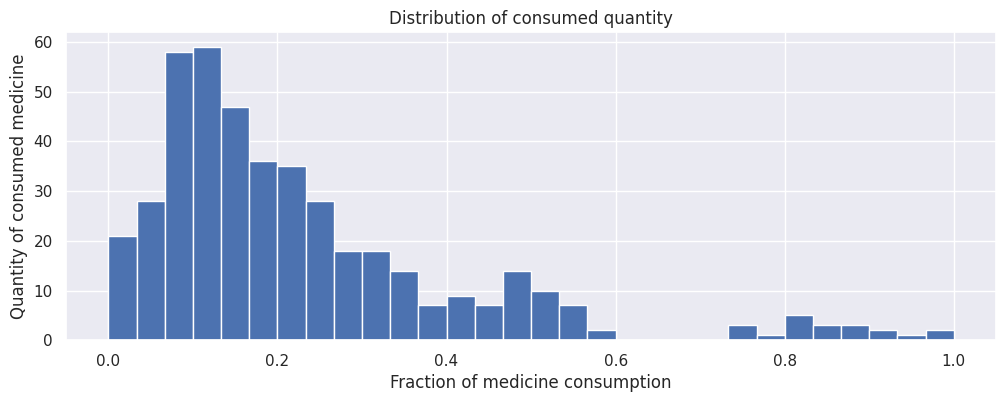

In [51]:
y = df_h1_c0["QUANTITY"] / df_h1_c0["QUANTITY"].max() # target rescale

fig, ax = plt.subplots(figsize=(12, 4))
y.hist(bins=30, ax=ax)
_ = ax.set(
    title="Distribution of consumed quantity",
    xlabel="Fraction of medicine consumption",
    ylabel="Quantity of consumed medicine",
)

In [169]:
# Select the columns to be encoded
columns_to_encode = ['ID_REF', 'CODE_ATC']

# Fill missing values in the columns to be encoded with a placeholder value
df_h1_c0_filled = df_h1_c0[columns_to_encode].fillna('NA')

# Perform one-hot encoding using pandas' get_dummies function
encoded_df = pd.get_dummies(df_h1_c0_filled)

# Merge the encoded columns back with the original DataFrame
df_h1_c0_onehot = pd.concat([df_h1_c0.drop(columns_to_encode, axis=1), encoded_df], axis=1)

X = df_h1_c0_onehot.drop(["QUANTITY","cluster"], axis="columns")
X

,YEAR,MONTH,N_UFS,WEEK,N_ETB,POPULATION,P_MEDICAL,PN_MEDICAL,LIT_HC,LIT_HP,...,CODE_ATC_H02AB06,CODE_ATC_J01CR05,CODE_ATC_M03BX01,CODE_ATC_N02AX02,CODE_ATC_N02BE01,CODE_ATC_N05BA04,CODE_ATC_N05BA12,CODE_ATC_N05CF01,CODE_ATC_N05CF02,CODE_ATC_R03AC02
30,2017,3,1,9.0,12,572443.0,806,5303,1360.0,106.0,...,0,0,0,0,0,0,0,0,0,0
123,2017,5,1,21.0,12,572443.0,806,5303,1360.0,106.0,...,0,1,0,0,0,0,0,0,0,0
180,2017,6,3,24.0,12,572443.0,806,5303,1360.0,106.0,...,0,0,0,0,0,0,0,0,0,0
185,2017,6,1,24.0,12,572443.0,806,5303,1360.0,106.0,...,0,0,0,0,0,0,0,0,0,0
186,2017,6,5,24.0,12,572443.0,806,5303,1360.0,106.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974,2019,3,8,9.0,12,569894.0,843,5438,1353.0,100.0,...,0,0,0,0,0,0,0,0,0,0
1982,2019,3,2,9.0,12,569894.0,843,5438,1353.0,100.0,...,0,0,0,0,0,0,0,0,0,0
1984,2019,3,5,9.0,12,569894.0,843,5438,1353.0,100.0,...,0,0,0,0,0,0,0,0,0,0
1985,2019,3,7,9.0,12,569894.0,843,5438,1353.0,100.0,...,0,0,0,0,0,1,0,0,0,0


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Score: 0.72


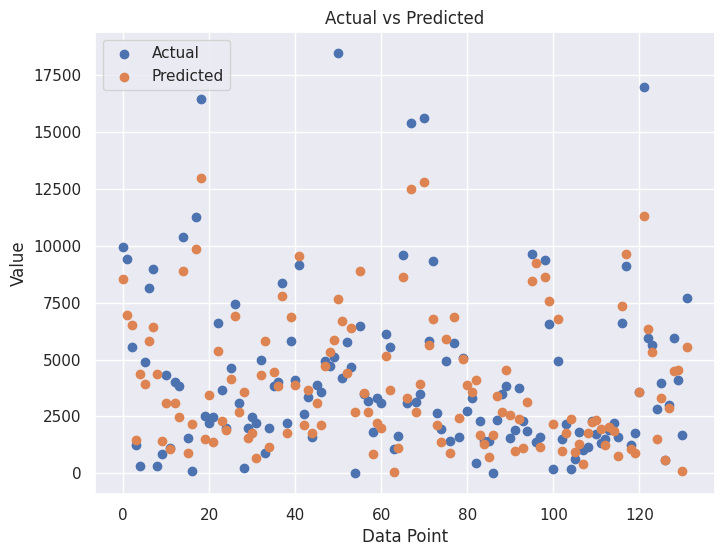

In [170]:
# Split the data into training and testing sets with a specific split size
X_train, X_test, y_train, y_test = train_test_split(X.values, df_h1_c0["QUANTITY"], test_size=0.30, random_state=42, shuffle=True)

# Create the pipeline with StandardScaler and MLPRegressor
pipe = make_pipeline(StandardScaler(), MLPRegressor(
    hidden_layer_sizes=(128,64,),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    learning_rate='constant',
    learning_rate_init=0.001,
    max_iter=200,
    shuffle=True,
    random_state=42
))

# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

# Evaluate the model on the testing data
score = pipe.score(X_test, y_test)

print(f"Model Score: {score:.2f}")

y_pred = pipe.predict(X_test)

plot_actual_vs_predicted(y_test, y_pred)

Model Score: 0.71


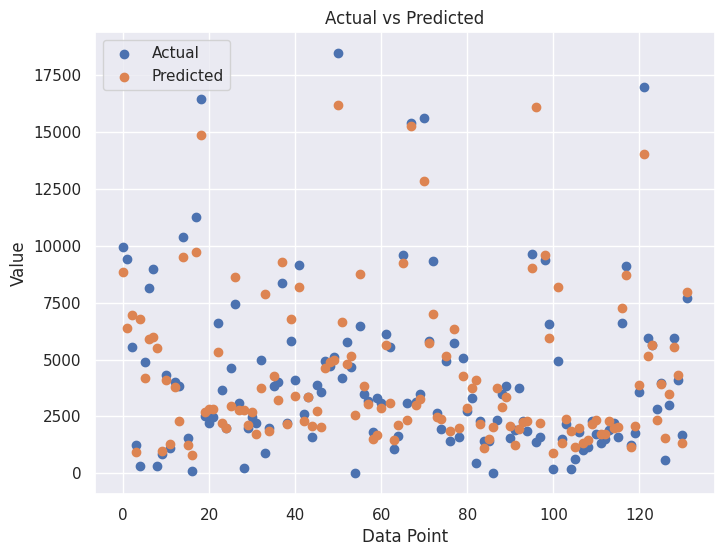

In [171]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.values, df_h1_c0["QUANTITY"],test_size=0.30, random_state=42,shuffle = True)

# Create the pipeline with StandardScaler and RandomForestRegressor
pipe = make_pipeline(StandardScaler(), RandomForestRegressor())

# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

# Evaluate the model on the testing data
score = pipe.score(X_test, y_test)

print(f"Model Score: {score:.2f}")

y_pred = pipe.predict(X_test)

plot_actual_vs_predicted(y_test, y_pred)

### Projection of one medicini consumption for the next 6 months

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


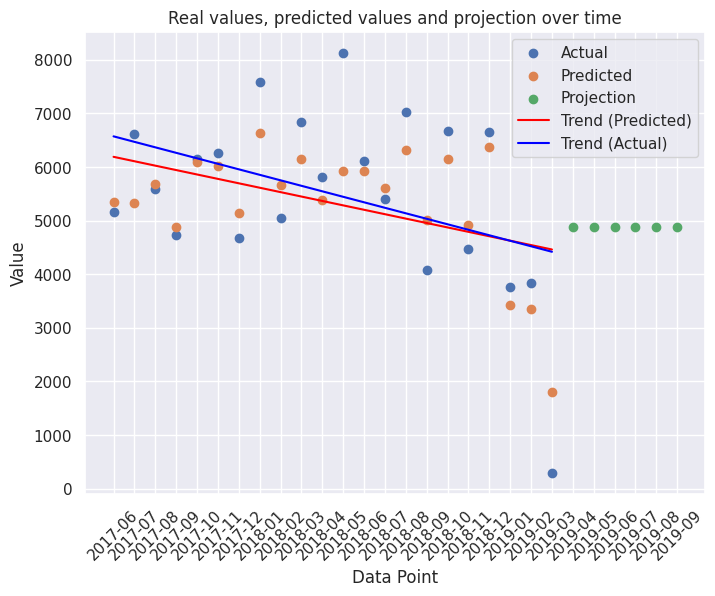

In [236]:
# Create a DataFrame for the future dates
future_dates = pd.date_range(start='2019-04', periods=6, freq='M')

# Create a DataFrame with the feature values for prediction
projection_data = pd.DataFrame({
    'YEAR': [2019] * 6,
    'MONTH': future_dates.month,
    'N_UFS': [8] * 6,
    'WEEK': [9] * 6,
    'N_ETB': [12] * 6,
    'POPULATION': [569894] * 6,
    'P_MEDICAL': [843] * 6,
    'PN_MEDICAL': [5438] * 6,
    'LIT_HC': [1353] * 6,
    'LIT_HP': [100] * 6,
    'SEJ_MCO': [82997] * 6,
    'SEJ_HAD': [0] * 6,
    'SEJ_PSY': [0] * 6,
    'SEJ_SSR': [1141] * 6,
    'SEJ_SLD': [92] * 6,
    'ID_REF_800851': [1] * 6,
    'ID_REF_800852': [0] * 6,
    'ID_REF_810359': [0] * 6,
    'ID_REF_820070': [0] * 6,
    'ID_REF_822707': [0] * 6,
    'ID_REF_830302': [0] * 6,
    'ID_REF_830303': [0] * 6,
    'ID_REF_830631': [0] * 6,
    'ID_REF_830701': [0] * 6,
    'ID_REF_840051': [0] * 6,
    'ID_REF_841268': [0] * 6,
    'ID_REF_890228': [0] * 6,
    'ID_REF_890264': [0] * 6,
    'ID_REF_890900': [0] * 6,
    'ID_REF_891086': [0] * 6,
    'ID_REF_893880': [0] * 6,
    'ID_REF_960148': [0] * 6,
    'ID_REF_960229': [0] * 6,
    'ID_REF_960388': [0] * 6,
    'ID_REF_960491': [0] * 6,
    'ID_REF_960687': [0] * 6,
    'CODE_ATC_A03AX12': [0] * 6,
    'CODE_ATC_A12BA01': [0] * 6,
    'CODE_ATC_B01AB05': [0] * 6,
    'CODE_ATC_B01AC06': [0] * 6,
    'CODE_ATC_B05XA03': [1] * 6,
    'CODE_ATC_B05XA09': [0] * 6,
    'CODE_ATC_C01CA03': [0] * 6,
    'CODE_ATC_C03CA01': [0] * 6,
    'CODE_ATC_H02AB06': [0] * 6,
    'CODE_ATC_J01CR05': [0] * 6,
    'CODE_ATC_M03BX01': [0] * 6,
    'CODE_ATC_N02AX02': [0] * 6,
    'CODE_ATC_N02BE01': [0] * 6,
    'CODE_ATC_N05BA04': [0] * 6,
    'CODE_ATC_N05BA12': [0] * 6,
    'CODE_ATC_N05CF01': [0] * 6,
    'CODE_ATC_N05CF02': [0] * 6,
    'CODE_ATC_R03AC02': [0] * 6
})

# Scale the projection data using the StandardScaler from the pipeline
scaled_projection_data = pipe.named_steps['standardscaler'].transform(projection_data)

# Make predictions for the scaled projection data
projections = pipe.predict(scaled_projection_data)

# Create a DataFrame to store the results
results = pd.DataFrame({
    'Date': future_dates,
    'Predicted Quantity': projections
})

#print(results)

dates = pd.to_datetime(df_h1_c0[df_h1_c0['ID_REF'] == '800851']["YEAR"].astype(str) + "-" + df_h1_c0[df_h1_c0['ID_REF'] == '800851']["MONTH"].astype(str))
formatted_dates = dates.dt.strftime('%Y-%m')
formatted_dates = pd.PeriodIndex(formatted_dates, freq='M')
formatted_dates = formatted_dates.astype(str)


# Filter X to include only rows where 'ID_REF_800851' is 1
X_filtered = X[X['ID_REF_800851'] == 1]

# Make predictions for the filtered data
y_pred = pipe.predict(X_filtered)

# Get the corresponding y values from the original DataFrame
y_real = df_h1_c0[df_h1_c0['ID_REF'] == '800851']['QUANTITY']

future_dates = future_dates.strftime('%Y-%m')
future_dates = future_dates.astype(str)

# Call the plot_actual_vs_predicted function with the correct inputs
plot_actual_vs_predicted(formatted_dates, y_real, y_pred, future_dates, projections, 'Real values, predicted values and projection over time')
